In [1]:
import math
import pandas as pd

In [2]:
augmented_data = pd.read_csv('./data/augmented_data.csv')

In [25]:
class NaiveBayes(object):
    #initialize model
    def __init__(self,data,training_split,laplace):
        self.num_rows = len(data)
        #shuffle data and reset indexes
        self.shuffled_data = data.sample(frac=1).reset_index(drop=True)
        #split the data into training and testing sets using input proportion 
        (self.training_data,self.testing_data) = self.training_testing_split(self.shuffled_data,training_split)
        self.num_training_rows,self.num_testing_rows = len(self.training_data),len(self.testing_data)
        self.smoothing_constant = laplace
        
    def training_testing_split(self,all_data,training_split):
        breakoff = int(self.num_rows*training_split)
        return (all_data.loc[:breakoff],all_data[['Text Command','Action']].loc[breakoff:])
         
    def action_map(self):
        return {0: 'To Do',1: 'In Progress',2: 'In Review',3: 'Blocked',4: 'Completed'}
    
    def index_action(self):
        return {'To Do': 0,'In Progress': 1,'In Review': 2,'Blocked': 3,'Completed': 4}
    
    # words to ignore when calculating probabilities
    def stopwords(self):
        return ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

    def compute_probabilities(self,text_command_training_data):
        action_map = self.action_map()
        action_probabilities = dict()
        action_dict = dict()
        word_dict = dict()
        word_counter = 0
        stopwords = self.stopwords()
        for action in list(action_map.values()):
            action_dict[action] = dict()
        for i in list(text_command_training_data.index.values):
            action = text_command_training_data.loc[i][1]
            action_probabilities[action] = action_probabilities.get(action,0) + 1
            text_command = text_command_training_data.loc[i][0]
            for word in text_command.lower().split():
                if word not in stopwords:
                    word_counter += 1
                    word_dict[word] = word_dict.get(word,0) + 1
                    action_dict[action][word] = action_dict[action].get(word,0) + 1
        num_unique_words = len(word_dict)
        for action in action_dict:
            num_words = sum(list(action_dict[action].values()))
            for word in action_dict[action]:
                action_dict[action][word] = (action_dict[action][word]+self.smoothing_constant)/(num_words+self.smoothing_constant*num_unique_words)
        for action in action_probabilities:
            action_probabilities[action] = action_probabilities[action]/self.num_training_rows
        
        for word in word_dict:
            word_dict[word] = (word_dict[word]+self.smoothing_constant)/(word_counter+self.smoothing_constant*num_unique_words)
        self.word_counter = word_counter # Why do you need this?
        return (action_probabilities,action_dict,word_dict)
    
    def train(self):
        text_command_and_action = self.training_data[['Text Command','Action']]
        (self.action_probabilities,self.action_dict,self.word_dict) = self.compute_probabilities(text_command_and_action)
    
    def predict(self,data):
        num_unique_words = len(self.word_dict)
        action_map = self.action_map()
        predictions = pd.DataFrame(columns=['Text Command', 'Predicted Action','Predicted Probabilities'])
        stopwords = self.stopwords()
        for i in list(data.index.values):
            words = data.loc[i][0].lower().split()
            action_probabilities = []
            denominator = 0
            for action in list(action_map.values()):
                num_words = sum(list(self.action_dict[action].values()))
                probability = 1
                for word in words:
                    if word not in stopwords:
                        probability = probability * self.action_dict[action].get(word,(self.smoothing_constant)/(num_words+self.smoothing_constant*num_unique_words))
                denominator += probability*self.action_probabilities[action]  
            for action in list(action_map.values()):
                num_words = sum(list(self.action_dict[action].values()))
                action_probability = self.action_probabilities[action]
                probability = 1
                for word in words:
                    if word not in stopwords:
                        probability = probability * self.action_dict[action].get(word,(self.smoothing_constant)/(num_words+self.smoothing_constant*num_unique_words))
                        
                probability = (probability * action_probability)/denominator
    
                
                action_probabilities.append(probability)
            predictions.loc[i]= [data.loc[i][0],action_map[action_probabilities.index(max(action_probabilities))],action_probabilities]
        return predictions
    
    def test(self):
        action_map = self.action_map()
        correct = 0
        preds = self.predict(self.testing_data)
        actions = self.testing_data['Action']
        for i in list(self.testing_data.index.values):
            if actions.loc[i][0] == preds['Predicted Action'].loc[i][0]:
                correct += 1
        losses = self.cross_entropy_loss(pd.concat([actions,preds['Predicted Probabilities']],axis=1))
                
        losses_total = 0
        for loss_idx in losses:
            # print('Cross Entropy Loss '+action_map[loss_idx]+': '+str(losses[loss_idx]))
            losses_total += losses[loss_idx]
        print('Accuracy: ' + str(correct/self.num_testing_rows), end='\r')
        print('Total Loss: ', losses_total, end='\r')
        return correct/self.num_testing_rows, losses_total, preds
    
    def cross_entropy_loss(self,labels):
        index_action = self.index_action()
        losses = {0: [],1: [],2: [],3: [], 4: []}
        for i in list(labels.index.values):
            idx = index_action[labels.loc[i][0]]
            loss = - math.log(labels.loc[i][1][idx])
            losses[idx].append(loss)
        for label in losses:
            losses[label] = sum(losses[label])/len(losses[label])
        return losses

In [26]:
classifier = NaiveBayes(augmented_data,0.8,1)

In [27]:
classifier.train()

In [28]:
classifier.test()

(0.9276018099547512,
 3.246514368944391,
                                 Text Command Predicted Action  \
 883                          Created X labor            To Do   
 884                   Task X is in follow-up        In Review   
 885                               get X task        In Review   
 886                        X tax is complete        Completed   
 887                   Start happening X task      In Progress   
 ...                                      ...              ...   
 1099  on that point is a problem with task X          Blocked   
 1100                         tax X completed        Completed   
 1101                         Starting X task      In Progress   
 1102            assign In Progress to decade      In Progress   
 1103                  put Y task In Progress      In Progress   
 
                                 Predicted Probabilities  
 883   [0.596635051316313, 0.09910217817247922, 0.081...  
 884   [0.10489401440585344, 0.2497768212486874

In [30]:
losses = []
accuracy = []
for i in range(100):
    classifier = NaiveBayes(augmented_data,0.8,1)
    classifier.train()
    acc, loss, pred = classifier.test()
    losses.append(loss)
    accuracy.append(acc)
print('Average total loss: ', sum(losses)/len(losses))
print('Average accuracy: ', sum(accuracy)/len(accuracy))

Average total loss:  3.2838312733040858
Average accuracy:  0.9110407239818998


## Algorithm Testing

In [3]:
temp_data = augmented_data.copy()
num_rows = len(temp_data)
shuffled_data = temp_data.sample(frac=1).reset_index(drop=True)

In [4]:
def training_testing_split(all_data,training_split):
        breakoff = int(num_rows*training_split)
        return (all_data.loc[:breakoff],all_data[['Text Command','Action']].loc[breakoff:])

training_data, testing_data = training_testing_split(augmented_data, 0.8)

In [5]:
training_data

,Text Command,Topic,Identifier,Action,One Hot Encoded Topic,One Hot Encoded Action,Verb/Noun
0,assign completed status to X,Task,X,Completed,"[1,0,0]","[0,0,0,0,1]",assign
1,move X to completed,Task,X,Completed,"[1,0,0]","[0,0,0,0,1]",move
2,X completed,Task,X,Completed,"[1,0,0]","[0,0,0,0,1]",completed
3,Completed X,Task,X,Completed,"[1,0,0]","[0,0,0,0,1]",completed
4,X in progress,Task,X,In Progress,"[1,0,0]","[0,1,0,0,0]",progress
...,...,...,...,...,...,...,...
879,Created labor X,Task,X,To Do,"[1,0,0]","[1,0,0,0,0]",created
880,Created chore X,Task,X,To Do,"[1,0,0]","[1,0,0,0,0]",created
881,Created green task X,Task,X,To Do,"[1,0,0]","[1,0,0,0,0]",created
882,Created radical task X,Task,X,To Do,"[1,0,0]","[1,0,0,0,0]",created


In [6]:
testing_data

,Text Command,Action
883,Created baby task X,To Do
884,Created novel task X,To Do
885,Created hot task X,To Do
886,Created new job X,To Do
887,Created new project X,To Do
...,...,...
1099,X task in survey,In Review
1100,X task in follow-up,In Review
1101,X task in critique,In Review
1102,X task in recap,In Review


In [7]:
num_training_rows, num_testing_rows = len(training_data), len(testing_data)
smoothing_constant = 1

text_command_and_action = training_data[['Text Command','Action']]

In [8]:
text_command_and_action

,Text Command,Action
0,assign completed status to X,Completed
1,move X to completed,Completed
2,X completed,Completed
3,Completed X,Completed
4,X in progress,In Progress
...,...,...
879,Created labor X,To Do
880,Created chore X,To Do
881,Created green task X,To Do
882,Created radical task X,To Do


In [9]:
text_command_training_data = text_command_and_action.copy()
action_map = {0: 'To Do',1: 'In Progress',2: 'In Review',3: 'Blocked',4: 'Completed'}
action_probabilities = dict()
action_dict = dict()
word_dict = dict()
word_counter = 0
stopwords = ["X", "Y", "x", "y", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
for action in list(action_map.values()):
    action_dict[action] = dict()
action_dict

{'To Do': {},
 'In Progress': {},
 'In Review': {},
 'Blocked': {},
 'Completed': {}}

In [10]:
for i in list(text_command_training_data.index.values):
    action = text_command_training_data.loc[i][1]
    action_probabilities[action] = action_probabilities.get(action,0) + 1
    text_command = text_command_training_data.loc[i][0]
    for word in text_command.lower().split():
        if word not in stopwords:
            word_counter += 1
            word_dict[word] = word_dict.get(word,0) + 1
            action_dict[action][word] = action_dict[action].get(word,0) + 1

In [11]:
text_command_training_data

,Text Command,Action
0,assign completed status to X,Completed
1,move X to completed,Completed
2,X completed,Completed
3,Completed X,Completed
4,X in progress,In Progress
...,...,...
879,Created labor X,To Do
880,Created chore X,To Do
881,Created green task X,To Do
882,Created radical task X,To Do


In [12]:
action_probabilities

{'Completed': 212,
 'In Progress': 226,
 'To Do': 131,
 'In Review': 206,
 'Blocked': 109}

In [13]:
word_dict

{'assign': 227,
 'completed': 66,
 'status': 10,
 'move': 5,
 'progress': 113,
 'create': 64,
 'new': 54,
 'task': 401,
 'called': 33,
 'review': 141,
 'blocked': 67,
 'complete': 54,
 'start': 36,
 'finished': 1,
 'created': 29,
 'started': 6,
 'starting': 6,
 'problem': 6,
 'put': 17,
 'attribute': 17,
 'ascribe': 17,
 'delegate': 17,
 'designate': 17,
 'accomplished': 14,
 'realized': 14,
 'consummated': 14,
 'condition': 1,
 'position': 1,
 'run': 1,
 'go': 6,
 'affect': 1,
 'strike': 1,
 'act': 1,
 'inch': 18,
 'internal': 18,
 'fashionable': 18,
 'stylish': 18,
 'inward': 18,
 'build': 16,
 'advance': 8,
 'progression': 8,
 'advancement': 8,
 'make': 8,
 'produce': 8,
 'green': 8,
 'radical': 8,
 'baby': 8,
 'novel': 7,
 'hot': 7,
 'job': 47,
 'project': 47,
 'tax': 47,
 'labor': 47,
 'chore': 47,
 'named': 3,
 'titled': 3,
 'known': 3,
 'survey': 13,
 'follow-up': 13,
 'critique': 13,
 'recap': 13,
 'refresh': 13,
 'closed': 12,
 'obstructed': 12,
 'use': 12,
 'good': 9,
 'sound

In [14]:
action_dict

{'To Do': {'create': 64,
  'new': 54,
  'task': 68,
  'called': 33,
  'created': 29,
  'make': 8,
  'produce': 8,
  'green': 8,
  'radical': 8,
  'baby': 8,
  'novel': 7,
  'hot': 7,
  'job': 10,
  'project': 10,
  'tax': 10,
  'labor': 10,
  'chore': 10,
  'named': 3,
  'titled': 3,
  'known': 3},
 'In Progress': {'progress': 113,
  'start': 36,
  'task': 111,
  'assign': 101,
  'started': 6,
  'starting': 6,
  'inch': 8,
  'internal': 8,
  'fashionable': 8,
  'stylish': 8,
  'inward': 8,
  'build': 16,
  'advance': 8,
  'progression': 8,
  'advancement': 8,
  'go': 5,
  'get': 5,
  'offset': 5,
  'begin': 5,
  'part': 5,
  'along': 3,
  'connected': 3,
  'happening': 3,
  'on-duty': 3,
  'duty': 3,
  'job': 7,
  'project': 7,
  'tax': 7,
  'labor': 7,
  'chore': 7,
  'put': 6,
  'attribute': 6,
  'ascribe': 6,
  'delegate': 6,
  'designate': 6,
  'cardinal': 3,
  'decade': 3,
  'ten': 3,
  '10': 3,
  'tenner': 3},
 'In Review': {'review': 141,
  'assign': 97,
  'task': 100,
  'inch':

**x and y aka the identifiers are in the word and action dict right now**

In [15]:
num_unique_words = len(word_dict)

In [16]:
for action in action_dict:
    num_words = sum(list(action_dict[action].values()))
    for word in action_dict[action]:
        action_dict[action][word] = ((action_dict[action][word]+smoothing_constant)
                                     /(num_words+smoothing_constant*num_unique_words))

In [17]:
action_dict

{'To Do': {'create': 0.14573991031390135,
  'new': 0.12331838565022421,
  'task': 0.1547085201793722,
  'called': 0.07623318385650224,
  'created': 0.06726457399103139,
  'make': 0.020179372197309416,
  'produce': 0.020179372197309416,
  'green': 0.020179372197309416,
  'radical': 0.020179372197309416,
  'baby': 0.020179372197309416,
  'novel': 0.017937219730941704,
  'hot': 0.017937219730941704,
  'job': 0.02466367713004484,
  'project': 0.02466367713004484,
  'tax': 0.02466367713004484,
  'labor': 0.02466367713004484,
  'chore': 0.02466367713004484,
  'named': 0.008968609865470852,
  'titled': 0.008968609865470852,
  'known': 0.008968609865470852},
 'In Progress': {'progress': 0.17325227963525835,
  'start': 0.05623100303951368,
  'task': 0.1702127659574468,
  'assign': 0.15501519756838905,
  'started': 0.010638297872340425,
  'starting': 0.010638297872340425,
  'inch': 0.013677811550151976,
  'internal': 0.013677811550151976,
  'fashionable': 0.013677811550151976,
  'stylish': 0.013

In [18]:
for action in action_probabilities:
    action_probabilities[action] = action_probabilities[action]/num_training_rows

In [19]:
action_probabilities

{'Completed': 0.2398190045248869,
 'In Progress': 0.25565610859728505,
 'To Do': 0.14819004524886878,
 'In Review': 0.2330316742081448,
 'Blocked': 0.12330316742081449}

In [20]:
word_dict

{'assign': 227,
 'completed': 66,
 'status': 10,
 'move': 5,
 'progress': 113,
 'create': 64,
 'new': 54,
 'task': 401,
 'called': 33,
 'review': 141,
 'blocked': 67,
 'complete': 54,
 'start': 36,
 'finished': 1,
 'created': 29,
 'started': 6,
 'starting': 6,
 'problem': 6,
 'put': 17,
 'attribute': 17,
 'ascribe': 17,
 'delegate': 17,
 'designate': 17,
 'accomplished': 14,
 'realized': 14,
 'consummated': 14,
 'condition': 1,
 'position': 1,
 'run': 1,
 'go': 6,
 'affect': 1,
 'strike': 1,
 'act': 1,
 'inch': 18,
 'internal': 18,
 'fashionable': 18,
 'stylish': 18,
 'inward': 18,
 'build': 16,
 'advance': 8,
 'progression': 8,
 'advancement': 8,
 'make': 8,
 'produce': 8,
 'green': 8,
 'radical': 8,
 'baby': 8,
 'novel': 7,
 'hot': 7,
 'job': 47,
 'project': 47,
 'tax': 47,
 'labor': 47,
 'chore': 47,
 'named': 3,
 'titled': 3,
 'known': 3,
 'survey': 13,
 'follow-up': 13,
 'critique': 13,
 'recap': 13,
 'refresh': 13,
 'closed': 12,
 'obstructed': 12,
 'use': 12,
 'good': 9,
 'sound

In [21]:
for word in word_dict:
    word_dict[word] = (word_dict[word]+smoothing_constant)/(word_counter+smoothing_constant*num_unique_words)

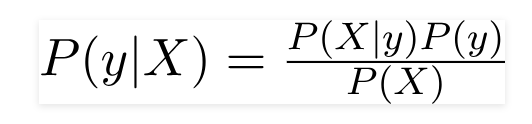

In [22]:
word_dict # P(X)

{'assign': 0.10594795539033457,
 'completed': 0.031133828996282528,
 'status': 0.005111524163568773,
 'move': 0.0027881040892193307,
 'progress': 0.05297397769516728,
 'create': 0.03020446096654275,
 'new': 0.025557620817843865,
 'task': 0.18680297397769516,
 'called': 0.015799256505576207,
 'review': 0.06598513011152417,
 'blocked': 0.031598513011152414,
 'complete': 0.025557620817843865,
 'start': 0.017193308550185873,
 'finished': 0.0009293680297397769,
 'created': 0.013940520446096654,
 'started': 0.0032527881040892194,
 'starting': 0.0032527881040892194,
 'problem': 0.0032527881040892194,
 'put': 0.008364312267657992,
 'attribute': 0.008364312267657992,
 'ascribe': 0.008364312267657992,
 'delegate': 0.008364312267657992,
 'designate': 0.008364312267657992,
 'accomplished': 0.006970260223048327,
 'realized': 0.006970260223048327,
 'consummated': 0.006970260223048327,
 'condition': 0.0009293680297397769,
 'position': 0.0009293680297397769,
 'run': 0.0009293680297397769,
 'go': 0.003

In [23]:
action_probabilities # P(y)

{'Completed': 0.2398190045248869,
 'In Progress': 0.25565610859728505,
 'To Do': 0.14819004524886878,
 'In Review': 0.2330316742081448,
 'Blocked': 0.12330316742081449}

In [24]:
action_dict # P(X|y)

{'To Do': {'create': 0.14573991031390135,
  'new': 0.12331838565022421,
  'task': 0.1547085201793722,
  'called': 0.07623318385650224,
  'created': 0.06726457399103139,
  'make': 0.020179372197309416,
  'produce': 0.020179372197309416,
  'green': 0.020179372197309416,
  'radical': 0.020179372197309416,
  'baby': 0.020179372197309416,
  'novel': 0.017937219730941704,
  'hot': 0.017937219730941704,
  'job': 0.02466367713004484,
  'project': 0.02466367713004484,
  'tax': 0.02466367713004484,
  'labor': 0.02466367713004484,
  'chore': 0.02466367713004484,
  'named': 0.008968609865470852,
  'titled': 0.008968609865470852,
  'known': 0.008968609865470852},
 'In Progress': {'progress': 0.17325227963525835,
  'start': 0.05623100303951368,
  'task': 0.1702127659574468,
  'assign': 0.15501519756838905,
  'started': 0.010638297872340425,
  'starting': 0.010638297872340425,
  'inch': 0.013677811550151976,
  'internal': 0.013677811550151976,
  'fashionable': 0.013677811550151976,
  'stylish': 0.013

In [ ]:
def predict(self,data):
    num_unique_words = len(self.word_dict)
    action_map = self.action_map()
    predictions = pd.DataFrame(columns=['Text Command', 'Predicted Action','Predicted Probabilities'])
    stopwords = self.stopwords()
    for i in list(data.index.values):
        words = data.loc[i][0].lower().split()
        action_probabilities = []
        denominator = 0
        for action in list(action_map.values()):
            num_words = sum(list(self.action_dict[action].values()))
            probability = 1
            for word in words:
                if word not in stopwords:
                    probability = probability * self.action_dict[action].get(word,(self.smoothing_constant)/(num_words+self.smoothing_constant*num_unique_words))
            denominator += probability*self.action_probabilities[action]  
        for action in list(action_map.values()):
            num_words = sum(list(self.action_dict[action].values()))
            action_probability = self.action_probabilities[action]
            probability = 1
            for word in words:
                if word not in stopwords:
                    probability = probability * self.action_dict[action].get(word,(self.smoothing_constant)/(num_words+self.smoothing_constant*num_unique_words))
            probability = (probability * action_probability)/denominator
            action_probabilities.append(probability)
        predictions.loc[i]= [data.loc[i][0],action_map[action_probabilities.index(max(action_probabilities))],action_probabilities]
    return predictions

In [ ]:
num_unique_words = len(word_dict)
action_map = self.action_map()
predictions = pd.DataFrame(columns=['Text Command', 'Predicted Action','Predicted Probabilities'])